# Find if cell type-associate and tissue-specific genes are regulated by different TFs

In [137]:
setwd("/frazer01/projects/CARDIPS/analysis/cardiac_eqtls")

source("script/packages.R"  )
source("script/input_data.R")
source("script/functions.R" )


In [138]:
gene_info               = fread("input/phenotypes/gene_info.txt"   , sep = "\t", header = TRUE, data.table = FALSE)
isof_info               = fread("input/phenotypes/isoform_info.txt", sep = "\t", header = TRUE, data.table = FALSE)
gene_info$transcript_id = gene_info$gene_id
promoters               = fread("/frazer01/reference/private/Gencode.v34lift37/promoters.bed", sep = "\t", header = FALSE, data.table = FALSE)


In [139]:
diffexp         = fread(paste("pipeline/4.1.differential_expression", paste("diffexp_cell_tissue", "txt", sep = "."), sep = "/"), sep = "\t", header = TRUE, data.table = FALSE)
diffexp         = diffexp[diffexp$name == "gene_tpm",]
diffexp$signif  = FALSE
diffexp$gene_id = diffexp$transcript_id
diffexp[diffexp$qval <= 0.05 & diffexp$beta > 0, "signif"] = TRUE


In [161]:
tmpwd = "pipeline/5.1.expression_enrichments/cell_type_enrichment_vs_bg"
dir.create(tmpwd, showWarnings = FALSE)

In [164]:
run_homer_tissue = function(tissue1, tissue2, cell, name, genes, isof_info, promoters)
{
    diffexp_genes         =        diffexp[diffexp$cell_type == cell &  diffexp$qval <= 0.05 & diffexp$beta > 0 , "transcript_id"]
    diffexp_genes         = unique(diffexp[diffexp$cell_type == cell & !diffexp$transcript_id %in% diffexp_genes, "transcript_id"])
    isoforms              = promoters[ promoters[,4] %in% isof_info[ isof_info$gene_id %in% genes, "transcript_id"],]
    isoforms_bg           = promoters[ promoters[,4] %in% isof_info[ isof_info$gene_id %in% diffexp_genes | isof_info$transcript_id %in% diffexp_genes, "transcript_id"],]
    colnames(isoforms)    = c("chrom", "from", "to", "transcript_id")
    colnames(isoforms_bg) = c("chrom", "from", "to", "transcript_id")
    isoforms              = merge(isoforms   , isof_info[,c("transcript_id", "strand")])
    isoforms_bg           = merge(isoforms_bg, isof_info[,c("transcript_id", "strand")])
    isoforms$score        = 0
    isoforms_bg$score     = 0
    isoforms              = isoforms   [order(isoforms   [,"chrom"], isoforms   [,"from"], isoforms   [,"to"]),]
    isoforms_bg           = isoforms_bg[order(isoforms_bg[,"chrom"], isoforms_bg[,"from"], isoforms_bg[,"to"]),]
    analysis_name         = paste(name, tissue1,       sep = ".")
    bg_name               = paste(name, tissue1, "bg", sep = ".")
    bed_file              = paste(tmpwd, paste(analysis_name,             "bed", sep = "."), sep = "/")
    bed_file_bg           = paste(tmpwd, paste(bg_name      ,             "bed", sep = "."), sep = "/")
    bed_file_bg_unmerged  = paste(tmpwd, paste(bg_name      , "unmerged", "bed", sep = "."), sep = "/")
    bed_file_unmerged     = paste(tmpwd, paste(analysis_name, "unmerged", "bed", sep = "."), sep = "/")
    motif_file            = "/frazer01/reference/public/hocomoco_v11/HOCOMOCOv11_core_HUMAN_mono_homer_format_0.0001.motif"

    fwrite(isoforms   [,c("chrom", "from", "to", "transcript_id", "score", "strand")], bed_file_unmerged   , sep = "\t", col.names = FALSE, row.names = FALSE)
    fwrite(isoforms_bg[,c("chrom", "from", "to", "transcript_id", "score", "strand")], bed_file_bg_unmerged, sep = "\t", col.names = FALSE, row.names = FALSE)
    
    system(paste("bedtools merge -c 4 -o distinct", "-i", bed_file_unmerged   , ">", bed_file   ))
    system(paste("bedtools merge -c 4 -o distinct", "-i", bed_file_bg_unmerged, ">", bed_file_bg))
    
    command = paste("findMotifsGenome.pl", bed_file, "hg19", paste(tmpwd, analysis_name, sep = "/"), 
                    "-mknown" , motif_file, 
                    "-mcheck" , motif_file, 
                    "-bg"     , bed_file_bg,
                    "-nomotif", 
                    "-size"   , 200,
                    "&"
                   )
    
    return(command)
}

enrichment_epigenome = function(diffexp, tissue1, tissue2, cell, isof_info, promoters)
{
    message(paste(tissue1, tissue2, cell))
    
    dif1  = diffexp[diffexp$cell_type == cell & diffexp$tissue == tissue1, c("gene_id", "beta", "se", "pval", "qval", "signif")]
    dif2  = diffexp[diffexp$cell_type == cell & diffexp$tissue == tissue2, c("gene_id", "beta", "se", "pval", "qval", "signif")]
    x     = merge(dif1, dif2, by = "gene_id", suffixes = 1:2)
    x$cat = "NS"
    
    x[x$signif1 == TRUE  & x$signif2 == TRUE , "cat"] = "both"
    x[x$signif1 == TRUE  & x$signif2 == FALSE, "cat"] = tissue1
    x[x$signif1 == FALSE & x$signif2 == TRUE , "cat"] = tissue2
    
    out = c(run_homer_tissue(tissue1, tissue2, cell, paste(sub("cibersort.regular\\.", "", cell), tissue1, tissue2, sep = "."), x[x$cat == tissue1, "gene_id"], isof_info, promoters),
            run_homer_tissue(tissue2, tissue1, cell, paste(sub("cibersort.regular\\.", "", cell), tissue1, tissue2, sep = "."), x[x$cat == tissue2, "gene_id"], isof_info, promoters),
            "wait;"
           )
    
    return(out)
}


tissues = c("ipsc_cvpc", "heart", "arteria")
cells   = sort(unique(diffexp$cell_type))
to_run = unlist(lapply(1:(length(tissues) - 1), function(ii)
{
    tissue1 = tissues[[ii]]
    out1    = unlist(lapply((ii + 1):length(tissues), function(jj)
    {
        tissue2 = tissues[[jj]]
        out2 = unlist(lapply(cells, function(cell)
        {
            enrichment_epigenome(diffexp, tissue1, tissue2, cell, isof_info, promoters)
        }))
        return(out2)
    }))
    return(out1)
}))


ipsc_cvpc heart cibersort.regular.cardiac_muscle

ipsc_cvpc heart cibersort.regular.cardiac_neuron

ipsc_cvpc heart cibersort.regular.endocardial

ipsc_cvpc heart cibersort.regular.endothelial

ipsc_cvpc heart cibersort.regular.fibroblast

ipsc_cvpc heart cibersort.regular.immune

ipsc_cvpc heart cibersort.regular.myofibroblast

ipsc_cvpc heart cibersort.regular.smooth_muscle

ipsc_cvpc arteria cibersort.regular.cardiac_muscle

ipsc_cvpc arteria cibersort.regular.cardiac_neuron

ipsc_cvpc arteria cibersort.regular.endocardial

ipsc_cvpc arteria cibersort.regular.endothelial

ipsc_cvpc arteria cibersort.regular.fibroblast

ipsc_cvpc arteria cibersort.regular.immune

ipsc_cvpc arteria cibersort.regular.myofibroblast

ipsc_cvpc arteria cibersort.regular.smooth_muscle

heart arteria cibersort.regular.cardiac_muscle

heart arteria cibersort.regular.cardiac_neuron

heart arteria cibersort.regular.endocardial

heart arteria cibersort.regular.endothelial

heart arteria cibersort.regular.fibrob

In [165]:
shfile = paste(tmpwd, "run_homer.sh", sep = ".")
writeLines(to_run, con = shfile, sep = "\n")

message(paste("nohup", "bash", shfile, "&"))

nohup bash pipeline/5.1.expression_enrichments/cell_type_enrichment_vs_bg.run_homer.sh &



In [183]:
diffexp[diffexp$gene_id %in% gene_info[gene_info$gene_name %in% c("TNNT2", "SCN5A"), "gene_id"] & diffexp$cell_type == "cibersort.regular.cardiac_muscle",]
gene_info[gene_info$gene_name %in% c("TNNT2", "SCN5A"), ]
str(diffexp)

,beta,se,tval,pval,cell_type,transcript_id,tissue,name,qval,signif,gene_id
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<lgl>,<chr>
33601,2.6156056,0.3826302,6.835857,1.322675e-10,cibersort.regular.cardiac_muscle,ENSG00000118194.20_8,ipsc_cvpc,gene_tpm,6.467247e-05,TRUE,ENSG00000118194.20_8
99425,0.7480288,0.1890436,3.956913,1.104214e-04,cibersort.regular.cardiac_muscle,ENSG00000183873.17_7,ipsc_cvpc,gene_tpm,1.000000e+00,FALSE,ENSG00000183873.17_7
196585,1.7409049,0.1616968,10.766475,4.395310e-24,cibersort.regular.cardiac_muscle,ENSG00000118194.20_8,heart,gene_tpm,2.149095e-18,TRUE,ENSG00000118194.20_8
262409,2.6806670,0.1594089,16.816292,4.377434e-49,cibersort.regular.cardiac_muscle,ENSG00000183873.17_7,heart,gene_tpm,2.140355e-43,TRUE,ENSG00000183873.17_7
359569,0.8653499,0.7107849,1.217457,2.242601e-01,cibersort.regular.cardiac_muscle,ENSG00000118194.20_8,arteria,gene_tpm,1.000000e+00,FALSE,ENSG00000118194.20_8
425393,4.2203053,0.7224898,5.841335,1.194904e-08,cibersort.regular.cardiac_muscle,ENSG00000183873.17_7,arteria,gene_tpm,5.842507e-03,TRUE,ENSG00000183873.17_7


,chrom,start,end,strand,gene_id,gene_name,gene_type,havana_gene,transcript_id
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
4570,chr1,201328136,201346892,-,ENSG00000118194.20_8,TNNT2,protein_coding,OTTHUMG00000035733.1_8,ENSG00000118194.20_8
39413,chr3,38589548,38691178,-,ENSG00000183873.17_7,SCN5A,protein_coding,OTTHUMG00000156166.1_7,ENSG00000183873.17_7


'data.frame':	488952 obs. of  11 variables:
 $ beta         : num  -0.528 -0.4248 2.2415 10.6438 -0.0714 ...
 $ se           : num  0.258 0.582 0.705 3.186 0.977 ...
 $ tval         : num  -2.049 -0.7299 3.1792 3.3407 -0.0731 ...
 $ pval         : num  0.04196 0.46642 0.00175 0.00102 0.94179 ...
 $ cell_type    : chr  "cibersort.regular.cardiac_muscle" "cibersort.regular.smooth_muscle" "cibersort.regular.endocardial" "cibersort.regular.immune" ...
 $ transcript_id: chr  "ENSG00000000003.15_5" "ENSG00000000003.15_5" "ENSG00000000003.15_5" "ENSG00000000003.15_5" ...
 $ tissue       : chr  "ipsc_cvpc" "ipsc_cvpc" "ipsc_cvpc" "ipsc_cvpc" ...
 $ name         : chr  "gene_tpm" "gene_tpm" "gene_tpm" "gene_tpm" ...
 $ qval         : num  1 1 1 1 1 1 1 1 1 1 ...
 $ signif       : logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ gene_id      : chr  "ENSG00000000003.15_5" "ENSG00000000003.15_5" "ENSG00000000003.15_5" "ENSG00000000003.15_5" ...


# Once Homer is run

In [175]:
motifs           = fread("/frazer01/reference/public/hocomoco_v11/HOCOMOCOv11_core_annotation_HUMAN_mono.tsv", sep = "\t", header = TRUE, data.table = FALSE)
motifs$gene_name = motifs[, "Transcription factor"]
colnames(motifs) = gsub(" ", "_", tolower(colnames(motifs)))


In [176]:
tissues = c("ipsc_cvpc", "heart", "arteria")
cells   = sort(unique(diffexp$cell_type))
enr     = lapply(1:(length(tissues) - 1), function(ii)
{
    tissue1 = tissues[[ii]]
    out1    = lapply((ii + 1):length(tissues), function(jj)
    {
        tissue2 = tissues[[jj]]
        out2 = lapply(cells, function(cell)
        {
            totest = c(tissue1, tissue2, "both")
            out3   = lapply(totest, function(tissue3)
            {
                infile           = paste(tmpwd, paste(sub("cibersort.regular\\.", "", cell), tissue1, tissue2, tissue3, sep = "."), "knownResults.txt", sep = "/")
                if(file.exists(infile) == TRUE)
                {
                    tf_up            = fread(infile, sep = "\t", header = TRUE, data.table = FALSE)
                    colnames(tf_up)  = c("model", "consensus", "pval", "logp", "qval", "in_n", "in_p", "out_n", "out_p")
                    tf_up$in_p       = as.numeric(gsub("%", "", tf_up$in_p ))
                    tf_up$out_p      = as.numeric(gsub("%", "", tf_up$out_p))
                    tf_up$log2r      = log2(tf_up$in_p / tf_up$out_p)
                    tf_up            = merge(motifs[,c("model", "gene_name", "quality", "tf_family", "tf_subfamily")], tf_up, by = "model")

                    return(tf_up)
                }
            })
            names(out3) = totest
            
            return(out3)
        })
        names(out2) = gsub("cibersort.regular\\.", "", cells)
        return(out2)
    })
    names(out1) = tissues[(ii + 1):length(tissues)]
    return(out1)
})

names(enr) = tissues[1:(length(tissues) - 1)]

saveRDS(enr, paste(tmpwd, "enrichment_cell_types.rds"))

In [177]:
suppressPackageStartupMessages(library(wordcloud))
suppressPackageStartupMessages(library(tm))

source("script/colors.R"    )


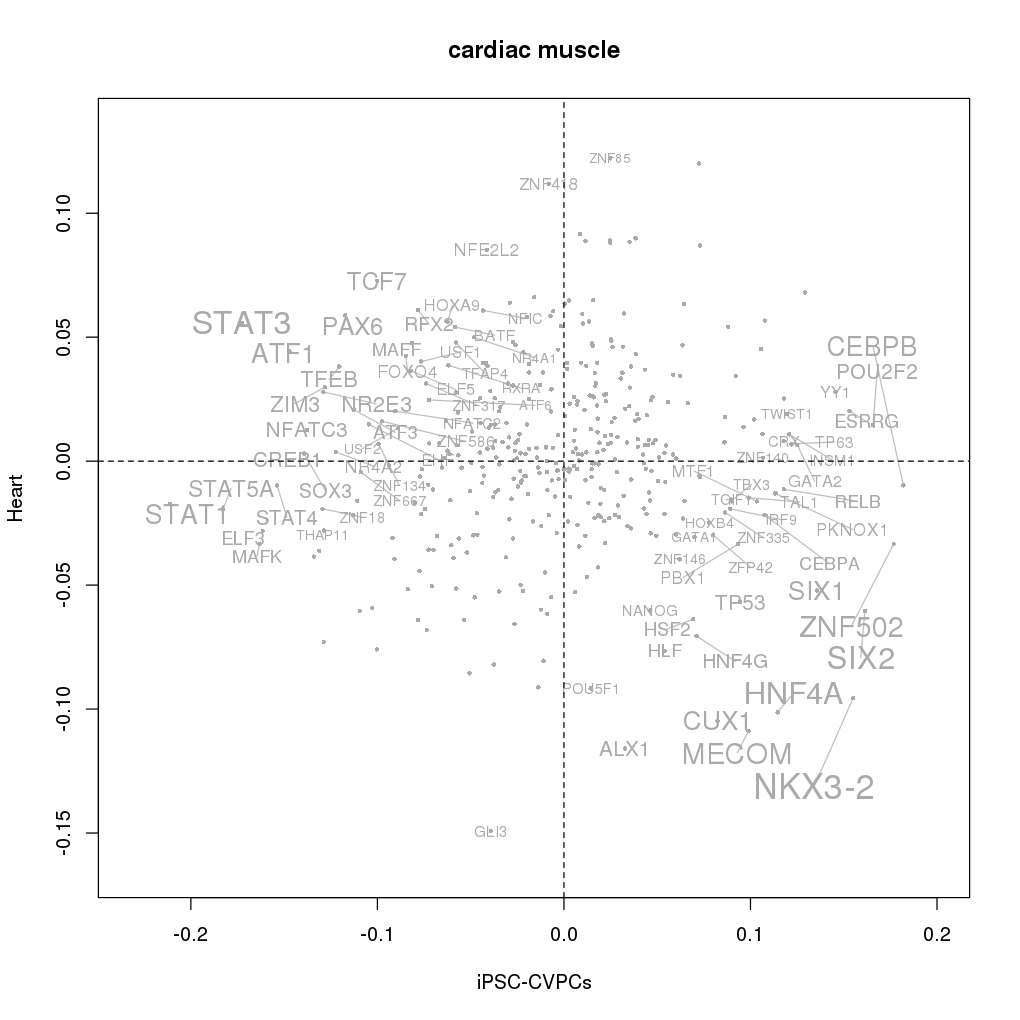

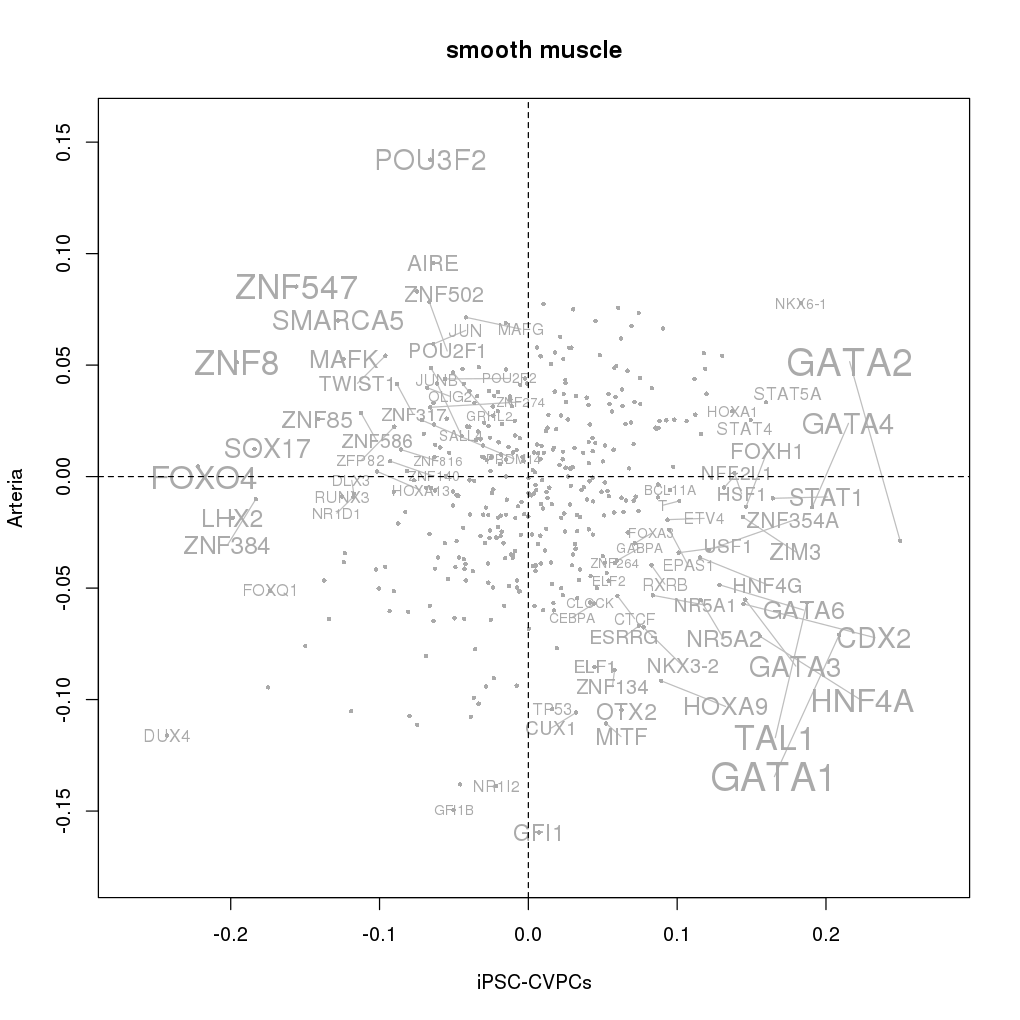

In [178]:
plot_homer = function(tissue1, tissue2, cell, enr)
{
    inlist    = enr[[tissue1]][[tissue2]][[cell]]
    tfs       = merge(inlist[[tissue1]], inlist[[tissue2]][,c("model", "pval", "logp", "qval", "in_n", "in_p", "out_n", "out_p", "log2r")], by = "model", suffixes = 1:2)
    tfs$delta = tfs$log2r1 - tfs$log2r2
    tfs       = tfs[order(tfs$delta),]
    tfs$color = "#aaaaaa"
    tfs[tfs$qval1 <= 0.05 & tfs$qval2 <= 0.05, "color"] = "#ff0000"
    tfs[tfs$qval1 <= 0.05 & tfs$qval2 >  0.05, "color"] = tissue2color3[tissue1, "color"]
    tfs[tfs$qval1 >  0.05 & tfs$qval2 <= 0.05, "color"] = tissue2color3[tissue2, "color"]

    #toplot  = tfs[tfs$color != "#aaaaaa",]
    toplot  = tfs[abs(tfs$delta) > quantile(abs(tfs$delta), probs = 0.8),]
    
    textplot(toplot$log2r1, toplot$log2r2, toplot$gene_name, cex = abs(toplot$delta)*7, col = toplot$color, xlim = range(toplot$log2r1) * 1.1, ylim = range(toplot$log2r2) * 1.1, xlab = tissue2color3[tissue1, "body_site"], ylab = tissue2color3[tissue2, "body_site"], main = gsub("_", " ", cell))
    points  (tfs   $log2r1, tfs   $log2r2, col = tfs$color, pch = 16, cex = 0.5)
    #plot(tfs$log2r1, tfs$log2r2, pch = 16, col = tfs$color)
    #
    #toplot = tfs[tfs$color != "#aaaaaa", ]
    #toplot = rbind(head(toplot, n = 5), tail(toplot, n = 5))
    abline(h = 0, lty = "dashed", col = "#000000")
    abline(v = 0, lty = "dashed", col = "#000000")
    #
    #text(x = toplot$log2r1, y = toplot$log2r2, labels = toplot$gene_name, pos = 3)
}

tissue1 = "ipsc_cvpc"
tissue2 = "heart"
cell    = "cardiac_muscle"

options(repr.plot.width = 8.5, repr.plot.height = 8.5)

plot_homer("ipsc_cvpc", "heart"  , "cardiac_muscle", enr)
#plot_homer("ipsc_cvpc", "heart"  , "smooth_muscle" , enr)
plot_homer("ipsc_cvpc", "arteria", "smooth_muscle" , enr)
#plot_homer("heart"    , "arteria", "smooth_muscle" , enr)
#plot_homer("ipsc_cvpc", "heart"  , "endocardial"   , enr)
#plot_homer("ipsc_cvpc", "arteria", "endocardial"   , enr)
#plot_homer("heart"    , "arteria", "endocardial"   , enr)
#plot_homer("ipsc_cvpc", "heart"  , "endothelial"   , enr)

#options(repr.plot.width = 15, repr.plot.height = 15)
#layout(matrix(1:9, nrow = 3, byrow = TRUE))
#invisible(lapply(gsub("cibersort.regular\\.", "", cells), function(cell){plot_homer(tissue1, tissue2, cell, enr)}))
